In [52]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

In [24]:
csv_file = '../data/cat_dog.csv'
data = pd.read_csv(csv_file)

In [27]:
image_paths = [os.path.join('../data/cat_dog', img_name) for img_name in data['image']]
labels = data['labels'].tolist()

## Предварительный анализ данных

In [36]:
def show_one_image_per_class(image_paths, labels):
    classes = set(labels)
    num_classes = len(classes)
    fig, axs = plt.subplots(1, num_classes, figsize=(5*num_classes, 5))

    for i, cls in enumerate(classes):
        class_images = [img_path for img_path, label in zip(image_paths, labels) if label == cls]
        sample_image = random.choice(class_images)

        img = plt.imread(sample_image)
        axs[i].imshow(img)
        axs[i].set_title(f'Class: {cls}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [43]:
def plot_class_distribution(labels):
    class_counts = {label: labels.count(label) for label in set(labels)}

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution (Histogram)')

    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%')
    plt.title('Class Distribution (Pie Chart)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def get_image_sizes(image_paths):
    sizes = []
    for img_path in image_paths:
        img = plt.imread(img_path)
        sizes.append(img.shape[:2])
    return sizes

In [47]:
def plot_image_sizes(image_paths):
    sizes = get_image_sizes(image_paths)
    width = [size[0] for size in sizes]
    height = [size[1] for size in sizes]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(width, bins=30, color='b', alpha=0.7)
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title('Width Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(height, bins=30, color='r', alpha=0.7)
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title('Height Distribution')

    plt.tight_layout()
    plt.show()

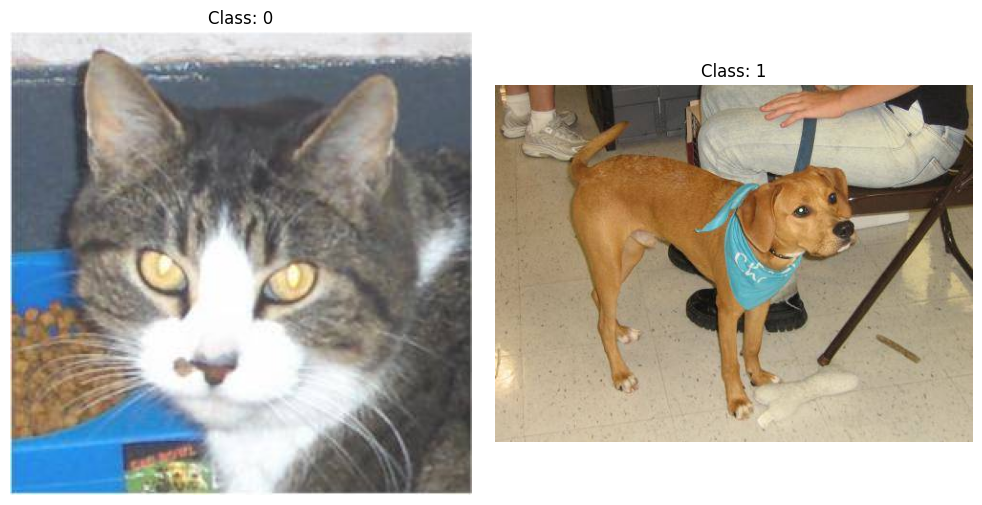

In [51]:
show_one_image_per_class(image_paths, labels)

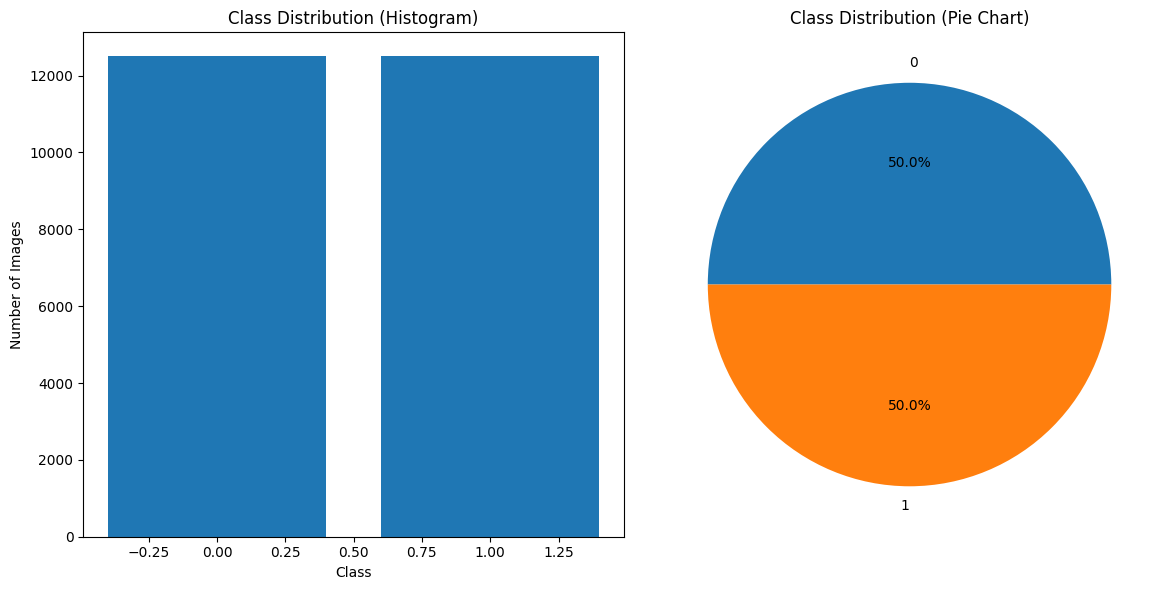

In [49]:
plot_class_distribution(labels)

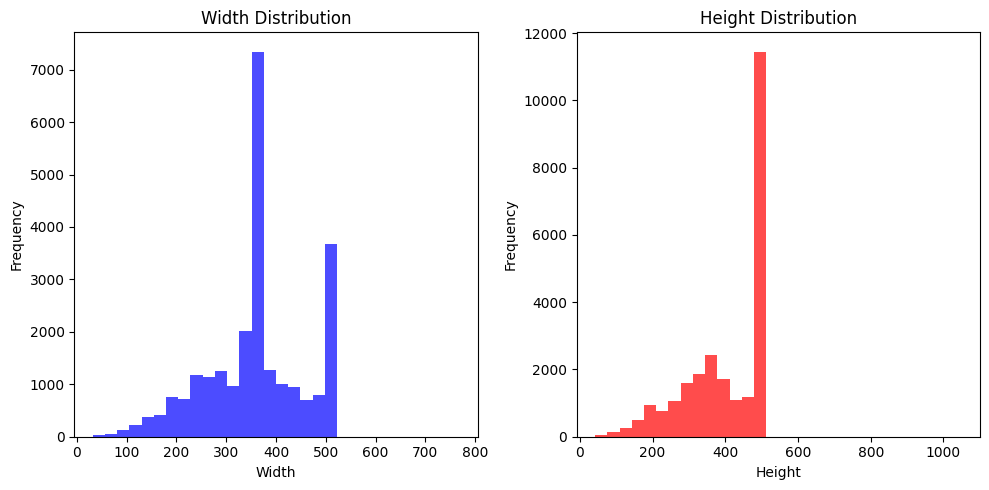

In [50]:
plot_image_sizes(image_paths)

## Подготовка данных

In [63]:
new_width = 64
new_height = 64

data_transform = transforms.Compose([
    transforms.Resize((new_width, new_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transformed_images = [data_transform(Image.open(img_path)) for img_path in image_paths]

In [65]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(transformed_images, labels, train_size=0.7, random_state=42, stratify=labels)

val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, train_size=0.5, random_state=42, stratify=val_test_labels)

In [66]:
len(train_data), len(val_data), len(test_data)

(17500, 3750, 3750)

In [68]:
train_data_tensor = torch.stack(train_data)
val_data_tensor = torch.stack(val_data)
test_data_tensor = torch.stack(test_data)

train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

In [70]:
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Моделирование